In [1]:
def getrelations(box1, box2, size1, size2):
    xywhb1 = box1.xywh
    xywhb2 = box2.xywh
    xyxyb1 = box1.xyxy[0]
    xyxyb2 = box2.xyxy[0]

    labelNames = { 
               0: 'circle',
               1: 'square',
               2: 'line',
               3: 'star',
               4: 'triangle'
            }

    # 1 inside 2, 2 inside 1, above, under, right, left

    # 1 inside 2
    if (xyxyb1[0] > xyxyb2[0]) and (xyxyb1[0] < xyxyb2[2]) and (xyxyb1[2] > xyxyb2[0]) and( xyxyb1[2] < xyxyb2[2]):
        if xyxyb1[1] > xyxyb2[1] and xyxyb1[1] < xyxyb2[3] and xyxyb1[3] > xyxyb2[1] and xyxyb1[3] < xyxyb2[3]:
            return "a " + size1 + " " + labelNames[int(box1.cls)] + " is inside a " + size2 + " " + labelNames[int(box2.cls)]
        
    # 2 inside 1 
    elif xyxyb2[0] > xyxyb1[0] and xyxyb2[0] < xyxyb1[2] and xyxyb2[2] > xyxyb1[0] and xyxyb2[2] < xyxyb1[2]:
        if xyxyb2[1] > xyxyb1[1] and xyxyb2[1] < xyxyb1[3] and xyxyb2[3] > xyxyb1[1] and xyxyb2[3] < xyxyb1[3]:
            return  "a " + size2 + " " + labelNames[int(box2.cls)] + " is inside a " + size1 + " " + labelNames[int(box1.cls)]
        


    # above and under --> x1 can be = x2 or = x2+50 or = x2-50 or between 
    
    if (xyxyb1[0] == xyxyb2[0] or (xyxyb1[0] < xyxyb2[0] and xyxyb1[0] >= xyxyb2[0]-50) or( xyxyb1[0] > xyxyb2[0] and xyxyb1[0] <= xyxyb2[0]+50)) and (xyxyb1[2] == xyxyb2[2] or (xyxyb1[2] < xyxyb2[2] and xyxyb1[2] >= xyxyb2[2]-50) or( xyxyb1[2] > xyxyb2[2] and xyxyb1[2] <= xyxyb2[2]+50)):
        # above
        if xyxyb1[1] > xyxyb2[1] and xyxyb1[3] > xyxyb2[3]:
            return "a " + size2 + " " + labelNames[int(box2.cls)] +  " is above a " + size1 + " " + labelNames[int(box1.cls)] 
        elif xyxyb2[1] > xyxyb1[1] and xyxyb2[3] > xyxyb1[3]:
            return "a " + size1 + " " + labelNames[int(box1.cls)] + " is above a " + size2 + " " + labelNames[int(box2.cls)] 
        
    # right
    elif xyxyb1[0] > xyxyb2[0]:
        return "a " + size1 + " " + labelNames[int(box1.cls)] +  " is on the left of a " + size2 + " " + labelNames[int(box2.cls)] 
        
    elif xyxyb1[0] < xyxyb2[0]:
        return  "a " + size1 + " " +labelNames[int(box1.cls)] + " is on the right of a " + size2 + " " + labelNames[int(box2.cls)] 

            
         
    


In [2]:
import cv2   
import numpy as np
from PIL import Image


def PreparePrediction(img, result):
    train_data = []
    # Set the threshold for object detection
    conf_threshold = 0.25

    # Set the threshold for non-maximum suppression
    nms_threshold = 0.4
    # Create a list to store the bounding boxes and class names for the detected objects
    boxes = []
    class_names2 = []
    # Number of detected shapes
    numcircles = 0
    numsquares = 0
    numlines = 0
    numstars = 0
    numtriangles = 0

    info = [None] * 23
    scores = []

    # Get the scores and the number of detected shapes
    for i in range(len(result.boxes.cls)):
        scores.append(float(result.boxes.cls[i]))
        if int(result.boxes.cls[i] == 0):
            numcircles +=1
        elif int(result.boxes.cls[i] == 1):
            numsquares+=1
        elif int(result.boxes.cls[i] == 2):
            numlines+=1
        elif int(result.boxes.cls[i] == 3):
            numstars+=1
        elif int(result.boxes.cls[i] == 4):  
            numtriangles+=1

    numofshapes = numcircles + numsquares + numlines + numstars + numtriangles           


    # Get the sizes of each shape (S , M , L , XL)
    xywh = result.boxes.xywh
    sizes = []
    for j in range(0, len(xywh)):
        size = ""
        wh = (int(xywh[j][2]) + int(xywh[j][3]))/2
        if wh <= 64:
            size = "Small"
        elif wh > 64 and wh <= 128:
            size = "Medium"
        elif wh > 128 and wh <= 192:
            size = "Large"
        elif wh > 192 and  wh <= 256:
            size = "Extra Large"           

        sizes.append([int(result.boxes.cls[j]), size])

    circlesizes = []
    squaresizes = []
    linesizes = []
    starsizes = []
    trianglesizes = []    


    for i in range(0, len(sizes)):
        if sizes[i][0] == 0:
            circlesizes.append(sizes[i][1])
        elif sizes[i][0] == 1:
            squaresizes.append(sizes[i][1])
        elif sizes[i][0] == 2:
           linesizes.append(sizes[i][1])
        elif sizes[i][0] == 3:
            starsizes.append(sizes[i][1])
        elif sizes[i][0] == 4:
            trianglesizes.append(sizes[i][1]) 

    if len(circlesizes) > 0:
        info[1] = numcircles , circlesizes
    else :
        info [1] = numcircles , []

    if len(squaresizes) > 0:        
        info[2] = numsquares , squaresizes
    else:
        info[2] = numsquares , []

    if len(linesizes) > 0:        
        info[3] = numlines , linesizes
    else:
        info[3] = numlines , []

    if len(starsizes) > 0:        
        info[4] = numstars , starsizes
    else:
        info[4] = numstars , []

    if len(trianglesizes) > 0:        
        info[5] = numtriangles , trianglesizes
    else:
        info[5] = numtriangles, []                  


    
    finalstr = "This scketch contains " + str(numofshapes) + " Total shapes "
    
    if numcircles >0:
        finalstr+= str(info[1][0]) + " circles and "
         

    if numsquares >0:
        finalstr+= str(info[2][0]) + " squares and "
         

    if numlines >0:
        finalstr+= str(info[3][0]) + " lines and "
          

    if numstars >0:
        finalstr+= str(info[4][0]) + " stars and "
                    

    if numtriangles >0:
        finalstr+= str(info[5][0]) + " triangles and "

    if numofshapes > 0:
        finalstr+= "The sketch looks like "

    bbb = result.boxes

    for i in range(0,len(bbb)-1):
        finalstr += str((getrelations(bbb[i] , bbb[i+1], sizes[i][1], sizes[i+1][1]))) + " "
        if i != len(bbb)-2:
            finalstr += "and "

    return finalstr





In [3]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

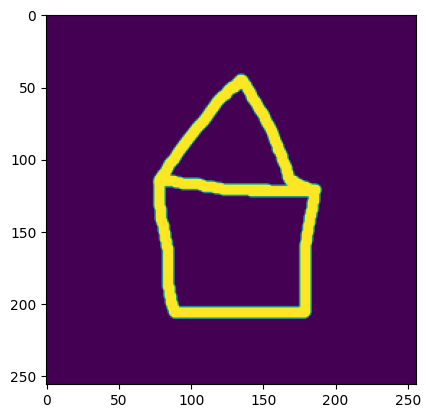


0: 640x640 1 square, 1 triangle, 80.6ms
Speed: 3.0ms preprocess, 80.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


This scketch contains 2 Total shapes 1 squares and 1 triangles and The sketch looks like a Medium triangle is above a Medium square 


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


house


In [22]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from transformers import BertTokenizer

Yolo_Model = YOLO(r'YoloComposedColab100\weights\best.pt')



img_arr = cv2.imread("Untitled.png", cv2.IMREAD_GRAYSCALE)
class_names= ['bicycle', 'house', 'laptop', 'lollipop', 'traffic_light']
image = cv2.resize(img_arr,(256,256))
image = image.astype('float32') 
image = image.reshape(1, 256, 256, 1)/255
image=Image.fromarray(np.uint8(image.reshape((256, 256))*255))
plt.imshow(image)
plt.show()                    
result = Yolo_Model.predict(source=image, save=False,  conf=0.25, task='detect')[0]
predtxt = PreparePrediction(image, result)
print(predtxt)




model =BertClassifier()
model.load_state_dict(torch.load(r"SavedModels\BERTPyTorchModel15EPOCHS.pth"))
model.eval()

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
encoded_inputs = tokenizer.encode_plus(predtxt, add_special_tokens=True, padding="max_length", max_length=128, truncation=True, return_tensors="pt")
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Perform the inference
with torch.no_grad():
    logits = model(input_ids, attention_mask)

# Process the output
predictions = torch.argmax(logits, dim=1)
print(class_names[int(predictions)])

